# ARIMA modeling of dtocs and ED breaches time series

Notes.  The analysis with is notebook fits a linear regression with ARIMA errors.  
See Rob Hyndman's blog for description of workings https://robjhyndman.com/hyndsight/arimax/

In [371]:
library(TSA)
library(car)
library(data.table)
library(ggplot2)
library(LSTS)
library(tseries)
library(lmtest)

In [232]:
#install.packages('LSTS', repos='http://cran.us.r-project.org')

Installing package into '\\filestore.soton.ac.uk/users/tm3y13/mydocuments/R/win-library/3.4'
(as 'lib' is unspecified)


package 'LSTS' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\tm3y13\AppData\Local\Temp\RtmpUZuDCd\downloaded_packages


In [7]:
dtoc = read.csv("input/dtoc.csv")
dtoc$yr = as.numeric(substr(dtoc$year, 1, 4))


year,month,total_atten,total_atten_t1,total_atten_.4hr,X95._targ,total_admissions,dtoc_a,dtoc_na,dtoc_total,mth,time,yr
2010-11,August,1719197,1138652,33184,0.9806980,425702.0,2559,2381,4940,8,1,2010
2010-11,September,1715117,1150728,41151,0.9760069,424900.0,2647,2357,5004,9,2,2010
2010-11,October,1753934,1163143,47414,0.9729671,436215.0,2513,2075,4588,10,3,2010
2010-11,November,1604591,1111295,46436,0.9710603,429099.0,2352,2057,4409,11,4,2010
2010-11,December,1647824,1159204,89917,0.9454327,452728.7,1995,1866,3861,12,5,2010
2010-11,January,1654907,1133881,72889,0.9559557,442003.7,2563,2034,4597,1,6,2010


In [9]:
dtoc['ln_breaches'] = log(dtoc['total_atten_.4hr'])

In [10]:
head(dtoc)

year,month,total_atten,total_atten_t1,total_atten_.4hr,X95._targ,total_admissions,dtoc_a,dtoc_na,dtoc_total,mth,time,yr,ln_breaches
2010-11,August,1719197,1138652,33184,0.9806980,425702.0,2559,2381,4940,8,1,2010,10.40982
2010-11,September,1715117,1150728,41151,0.9760069,424900.0,2647,2357,5004,9,2,2010,10.62500
2010-11,October,1753934,1163143,47414,0.9729671,436215.0,2513,2075,4588,10,3,2010,10.76667
2010-11,November,1604591,1111295,46436,0.9710603,429099.0,2352,2057,4409,11,4,2010,10.74583
2010-11,December,1647824,1159204,89917,0.9454327,452728.7,1995,1866,3861,12,5,2010,11.40664
2010-11,January,1654907,1133881,72889,0.9559557,442003.7,2563,2034,4597,1,6,2010,11.19669


## Initial time series plots

Breaches and DToCs: Plots before and after taking natural log

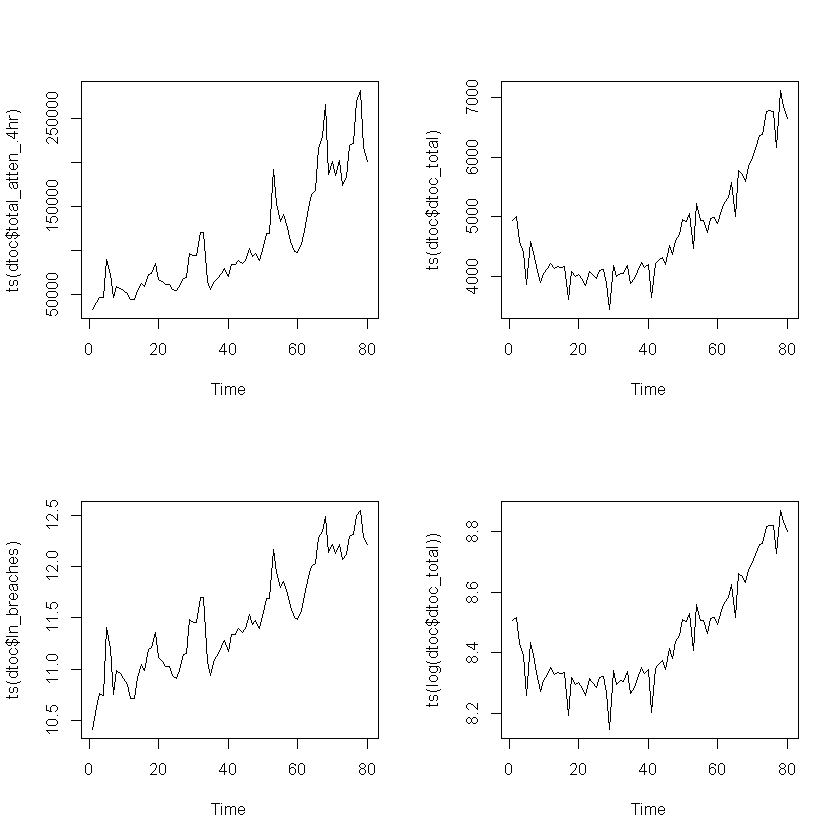

In [13]:
par(mfrow=c(2,2))

plot.ts(ts(dtoc$total_atten_.4hr),xy.lines=F,xy.labels=F) #  (increasing variance)
plot.ts(ts(dtoc$dtoc_total),xy.lines=F,xy.labels=F)

plot.ts(ts(dtoc$ln_breaches),xy.lines=F,xy.labels=F) #  (increasing variance)
plot.ts(ts(log(dtoc$dtoc_total)),xy.lines=F,xy.labels=F)

Stationarity - take first difference then plot and apply dickey fuller

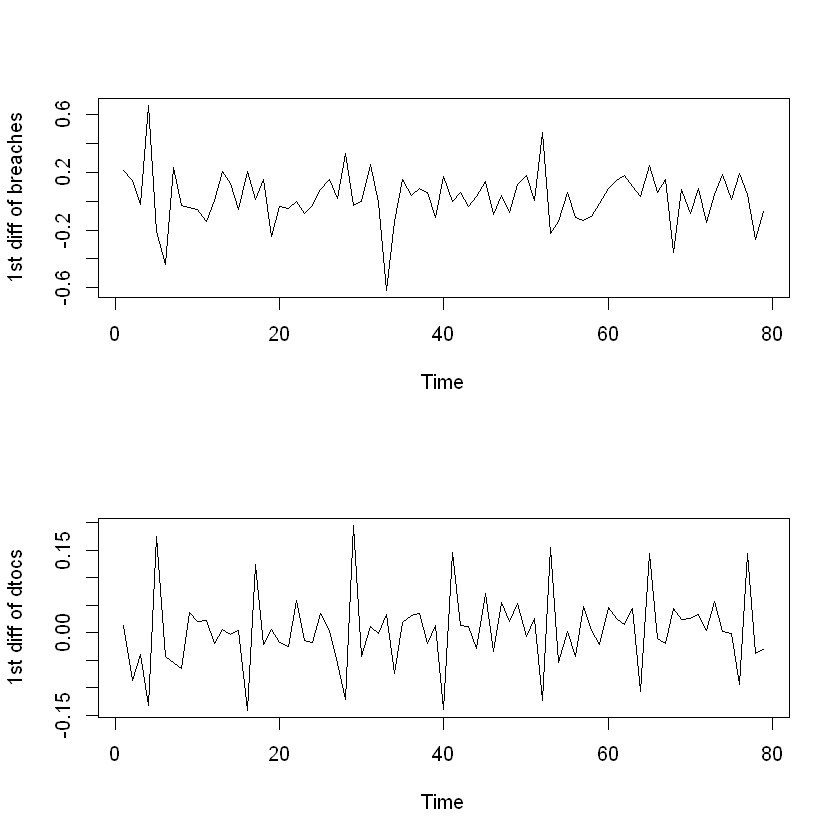

In [109]:
par(mfrow=c(2,1))

plot.ts(ts(diff(log(dtoc$total_atten_.4hr))),xy.lines=F,xy.labels=F,
       ylab="1st diff of breaches") #  (increasing variance)
plot.ts(ts(diff(log(dtoc$dtoc_total))),xy.lines=F,xy.labels=F,
       ylab="1st diff of dtocs")


Both series 'appear' stationary, but appear to have seasonal patterns.  Check ACF and PACF

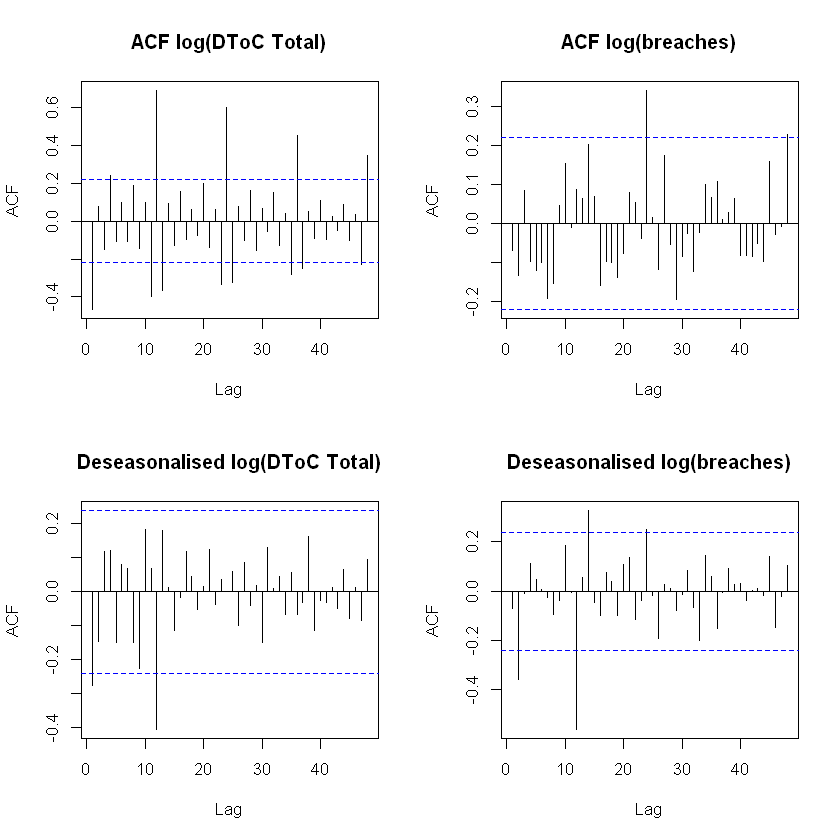

In [113]:
par(mfrow=c(2,2))
acf(diff(log(dtoc$dtoc_total)), lag.max = 48, main = "ACF log(DToC Total)")
acf(diff(log(dtoc$total_atten_.4hr)), lag.max = 48, main = "ACF log(breaches)")

acf(diff(diff(log(dtoc$dtoc_total), 12)), lag.max = 48, main = "Deseasonalised log(DToC Total)")
acf(diff(diff(log(dtoc$total_atten_.4hr),12)), lag.max = 48, main = "Deseasonalised log(breaches)")

Strong seasonal spikes at multiples of lag 12.  This look better after 1st seasonal diff. Conclusion.  Take seasonal difference

## Initital ARIMA modelling.  Breaches

breaches
tentative models: 

1. arima(1,1,0).(0,1,0)
2. arima(0,1,2).(0,1,0)
3. arima(1,1,1).(1,1,0)

In [238]:
plot_diag <- function(model){
    par(mfrow=c(2,1))
    acf(model$residuals, lag.max=48)
    pacf(model$residuals, lag.max=48)
    #library(FitAR)
    Box.Ljung.Test(model$residuals, lag = 24)
    #boxresult=LjungBoxTest(dtoc.m1$residuals,k=2,StartLag=1)
    #plot(boxresult[,3],main= "Ljung-Box Q Test", ylab= "P-values", xlab= "Lag")
    qqnorm(model$residuals)
    qqline(model$residuals)
    }

Simple and quick prewhitening

In [372]:
data.diff = ts.intersect(ts(diff(diff(log(dtoc$total_atten_.4hr), 12))),
                             ts(diff(diff(log(dtoc$dtoc_total), 12))))

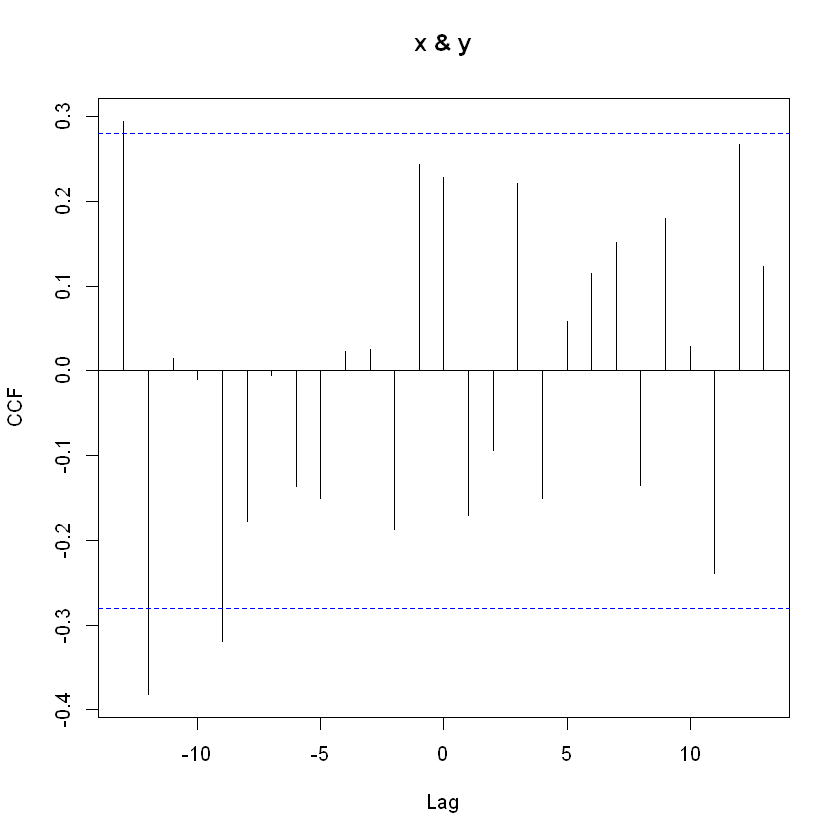

In [373]:
prewhiten(as.vector(data.diff[,1]), as.vector(data.diff[,2]),
         ylab='CCF')

In [374]:
data.reg = ts.intersect(ts(log(dtoc$total_atten_.4hr)),
                             ts(log(dtoc$dtoc_total)))

breaches = data.reg[,1]
dtocs = data.reg[,2]
m1 = lm(breaches ~ dtocs, data = data.reg)
summary(m1)


Call:
lm(formula = breaches ~ dtocs, data = data.reg)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.19443 -0.12911 -0.01013  0.16041  0.78765 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -7.8267     1.7791  -4.399  3.4e-05 ***
dtocs         2.2846     0.2106  10.851  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3314 on 78 degrees of freedom
Multiple R-squared:  0.6015,	Adjusted R-squared:  0.5964 
F-statistic: 117.7 on 1 and 78 DF,  p-value: < 2.2e-16


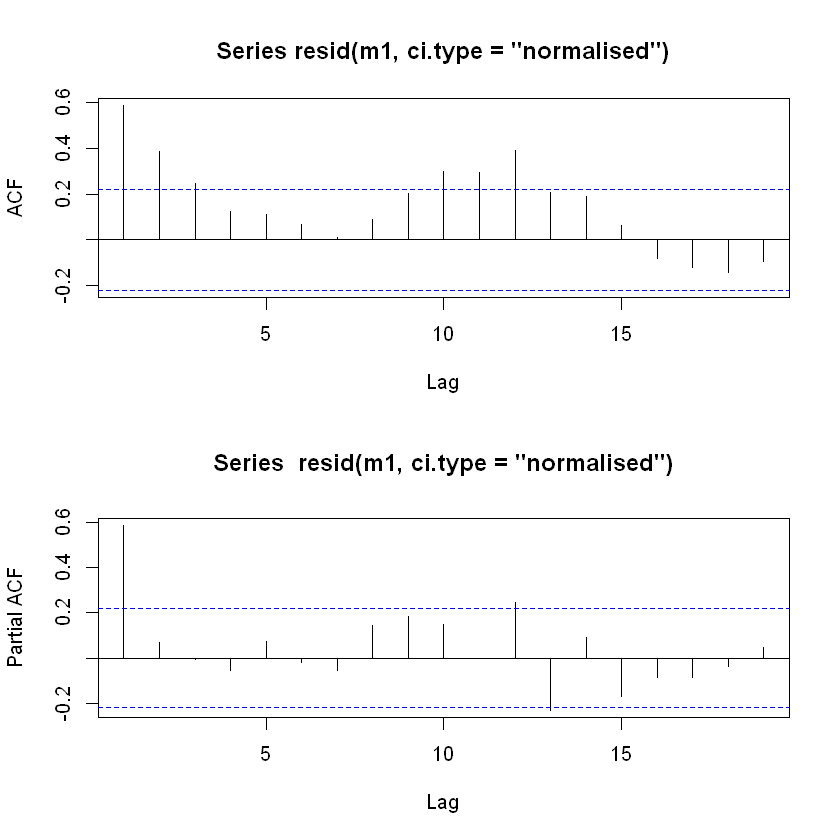

In [376]:
par(mfrow=c(2,1))
acf(resid(m1, ci.type="normalised"))
pacf(resid(m1, ci.type="normalised"))

In [377]:
m2 = arima(breaches, order=c(1,1,0),
           seasonal = list(order =c(0,1,0), period = 12),
           xreg=data.frame(dtocs)); m2

m3 = arima(breaches, order=c(1,1,0),
           seasonal = list(order =c(1,1,0), period = 12),
           xreg=data.frame(dtocs)); m3

m4 = arima(breaches, order=c(1,1,0),
           seasonal = list(order =c(1,1,0), period = 12),
           xreg=data.frame(dtocs)); m4

m5 = arima(breaches, order=c(1,1,1),
           seasonal = list(order =c(1,1,0), period = 12),
           xreg=data.frame(dtocs)); m5



Call:
arima(x = breaches, order = c(1, 1, 0), seasonal = list(order = c(0, 1, 0), 
    period = 12), xreg = data.frame(dtocs))

Coefficients:
          ar1   dtocs
      -0.0733  0.2999
s.e.   0.1222  0.6981

sigma^2 estimated as 0.05213:  log likelihood = 3.89,  aic = -3.77


Call:
arima(x = breaches, order = c(1, 1, 0), seasonal = list(order = c(1, 1, 0), 
    period = 12), xreg = data.frame(dtocs))

Coefficients:
          ar1     sar1   dtocs
      -0.1116  -0.6837  0.3746
s.e.   0.1246   0.0857  0.5964

sigma^2 estimated as 0.02769:  log likelihood = 21.29,  aic = -36.59


Call:
arima(x = breaches, order = c(1, 1, 0), seasonal = list(order = c(1, 1, 0), 
    period = 12), xreg = data.frame(dtocs))

Coefficients:
          ar1     sar1   dtocs
      -0.1116  -0.6837  0.3746
s.e.   0.1246   0.0857  0.5964

sigma^2 estimated as 0.02769:  log likelihood = 21.29,  aic = -36.59


Call:
arima(x = breaches, order = c(1, 1, 1), seasonal = list(order = c(1, 1, 0), 
    period = 12), xreg = data.frame(dtocs))

Coefficients:
         ar1      ma1     sar1   dtocs
      0.6170  -1.0000  -0.6724  0.5235
s.e.  0.1093   0.0545   0.0885  0.3183

sigma^2 estimated as 0.02307:  log likelihood = 25.74,  aic = -43.47

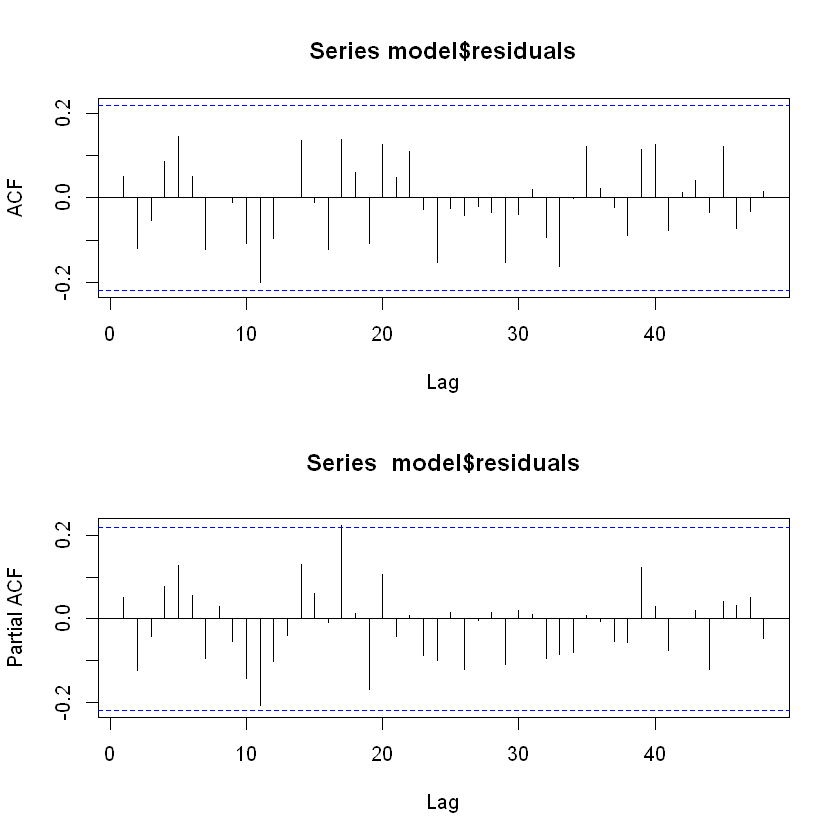

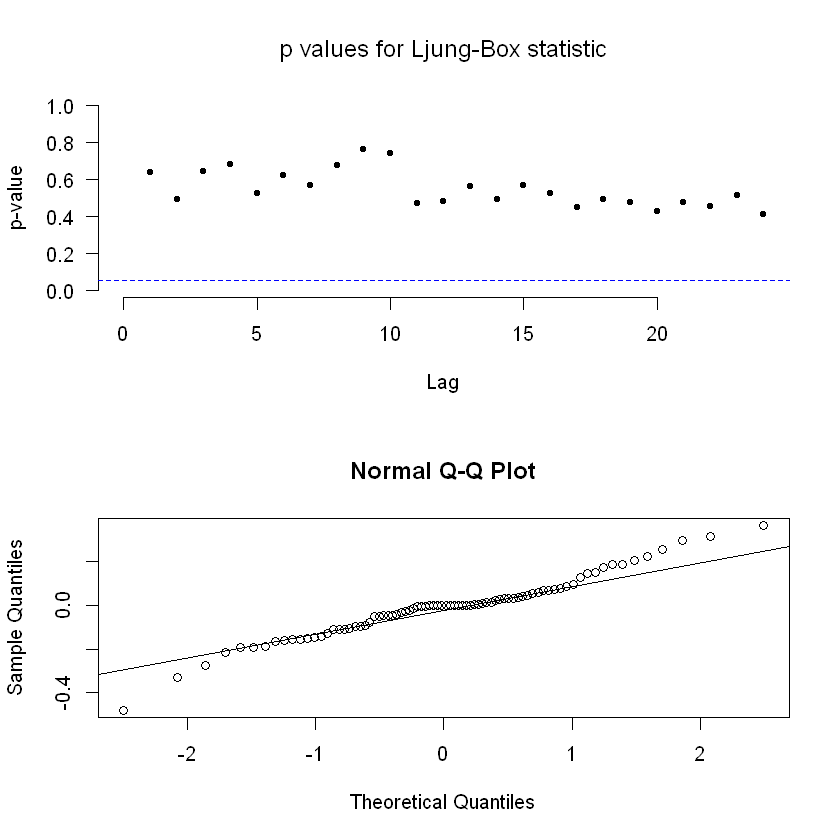

In [378]:
plot_diag(m5)

In [379]:
coeftest(m5)


z test of coefficients:

       Estimate Std. Error  z value  Pr(>|z|)    
ar1    0.616967   0.109320   5.6437 1.664e-08 ***
ma1   -0.999999   0.054477 -18.3562 < 2.2e-16 ***
sar1  -0.672402   0.088513  -7.5966 3.040e-14 ***
dtocs  0.523526   0.318334   1.6446    0.1001    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Outlier detection

In [380]:
detectAO(m5)

[1] "No AO detected"


In [310]:
detectIO(m5)

             [,1]
ind     34.000000
lambda1 -3.917797


Point 34 identified as innovative outlier

In [381]:
m6 = arima(breaches, order=c(1,1,1),
           seasonal = list(order =c(1,1,0), period = 12),
           xreg=data.frame(dtocs), io=c(34)); m6


Call:
arima(x = breaches, order = c(1, 1, 1), seasonal = list(order = c(1, 1, 0), 
    period = 12), xreg = data.frame(dtocs), io = c(34))

Coefficients:
         ar1      ma1     sar1   dtocs    IO.34
      0.6915  -0.9770  -0.6960  0.4606  -0.4953
s.e.  0.1069   0.0569   0.0813  0.3621   0.1481

sigma^2 estimated as 0.01998:  log likelihood = 30.91,  aic = -51.83

In [382]:
coeftest(m6)


z test of coefficients:

       Estimate Std. Error  z value  Pr(>|z|)    
ar1    0.691464   0.106945   6.4656 1.009e-10 ***
ma1   -0.976969   0.056912 -17.1664 < 2.2e-16 ***
sar1  -0.695990   0.081265  -8.5645 < 2.2e-16 ***
dtocs  0.460597   0.362064   1.2721 0.2033219    
IO.34 -0.495316   0.148146  -3.3434 0.0008275 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


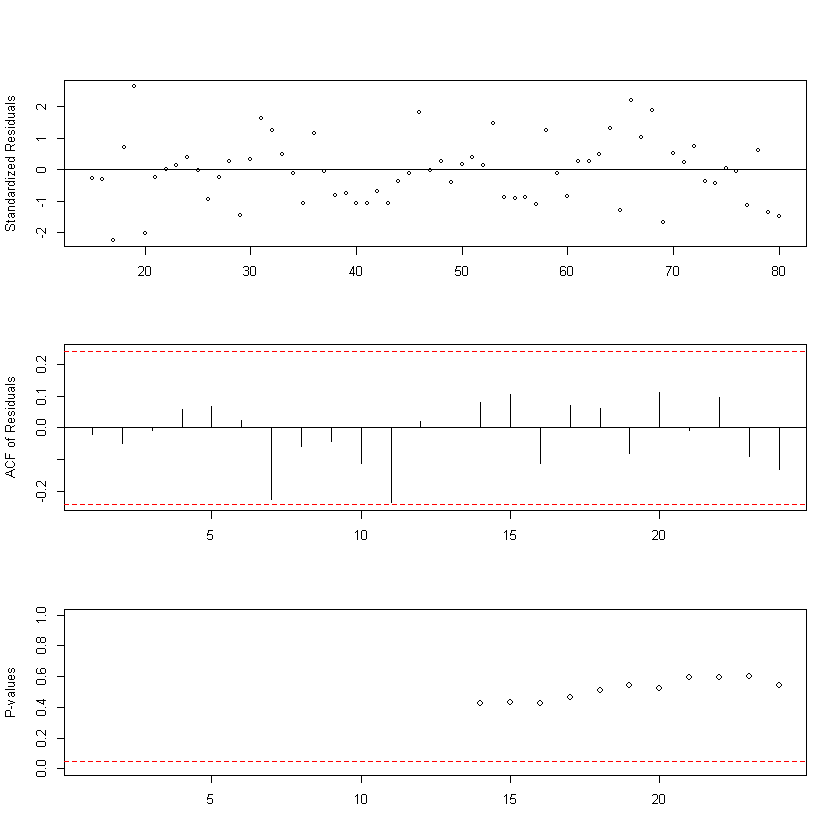

In [383]:
tsdiag(m6, tol=.15,gof.lag=24)

Approximate goodness of fit correlation^2

In [386]:
cor(fitted(m6),breaches)^2

[1] 0.9388813

## Add in total admissions

In [393]:
admissions = ts(log(dtoc$total_admissions))

m7 = arima(breaches, order=c(1,1,1),
           seasonal = list(order =c(1,1,0), period = 12),
           xreg=data.frame(dtocs, admissions), io=c(34));m7




Call:
arima(x = breaches, order = c(1, 1, 1), seasonal = list(order = c(1, 1, 0), 
    period = 12), xreg = data.frame(dtocs, admissions), io = c(34))

Coefficients:
         ar1      ma1     sar1   dtocs  admissions    IO.34
      0.3765  -0.6471  -0.6801  1.0403      2.3929  -0.5447
s.e.  0.2988   0.2591   0.0812  0.4792      0.8524   0.1409

sigma^2 estimated as 0.01879:  log likelihood = 34.27,  aic = -56.54

In [394]:
coeftest(m7)


z test of coefficients:

           Estimate Std. Error z value  Pr(>|z|)    
ar1         0.37647    0.29881  1.2599  0.207712    
ma1        -0.64712    0.25907 -2.4978  0.012496 *  
sar1       -0.68007    0.08118 -8.3773 < 2.2e-16 ***
dtocs       1.04028    0.47920  2.1709  0.029940 *  
admissions  2.39292    0.85236  2.8074  0.004994 ** 
IO.34      -0.54471    0.14093 -3.8651  0.000111 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


AR(1) term no longer significant.  Drop from model.

In [395]:
m7 = arima(breaches, order=c(0,1,1),
           seasonal = list(order =c(1,1,0), period = 12),
           xreg=data.frame(dtocs, admissions), io=c(34));m7


Call:
arima(x = breaches, order = c(0, 1, 1), seasonal = list(order = c(1, 1, 0), 
    period = 12), xreg = data.frame(dtocs, admissions), io = c(34))

Coefficients:
          ma1     sar1   dtocs  admissions    IO.34
      -0.2915  -0.6792  1.1273      2.5746  -0.5770
s.e.   0.1339   0.0808  0.4895      0.8504   0.1399

sigma^2 estimated as 0.01928:  log likelihood = 33.46,  aic = -56.91

In [396]:
coeftest(m7)


z test of coefficients:

            Estimate Std. Error z value  Pr(>|z|)    
ma1        -0.291501   0.133893 -2.1771  0.029471 *  
sar1       -0.679212   0.080767 -8.4096 < 2.2e-16 ***
dtocs       1.127267   0.489457  2.3031  0.021273 *  
admissions  2.574611   0.850436  3.0274  0.002467 ** 
IO.34      -0.577002   0.139867 -4.1254 3.701e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


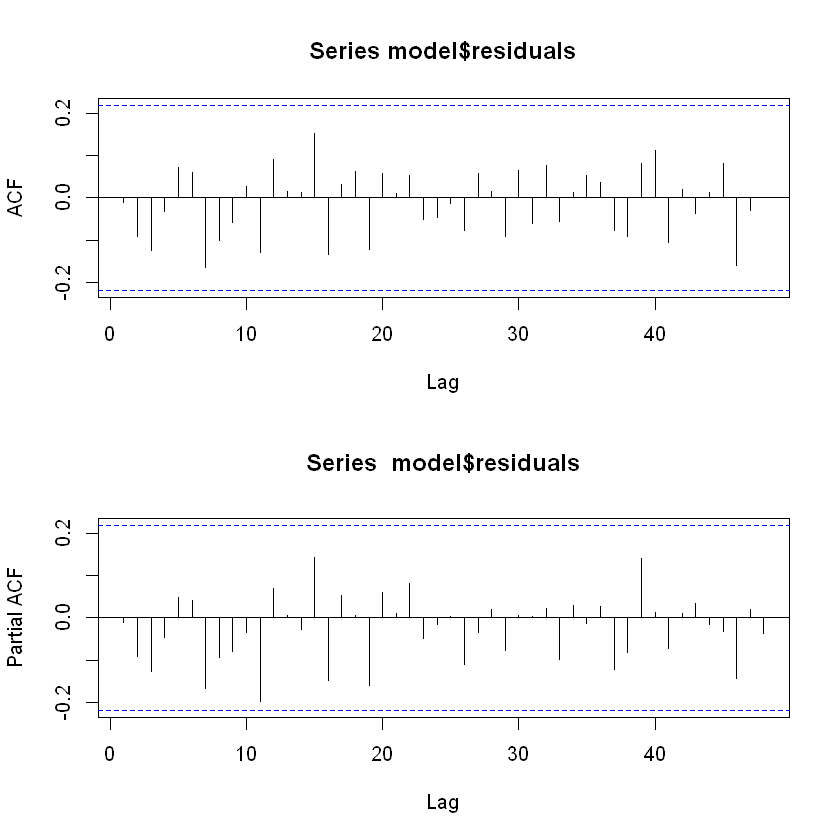

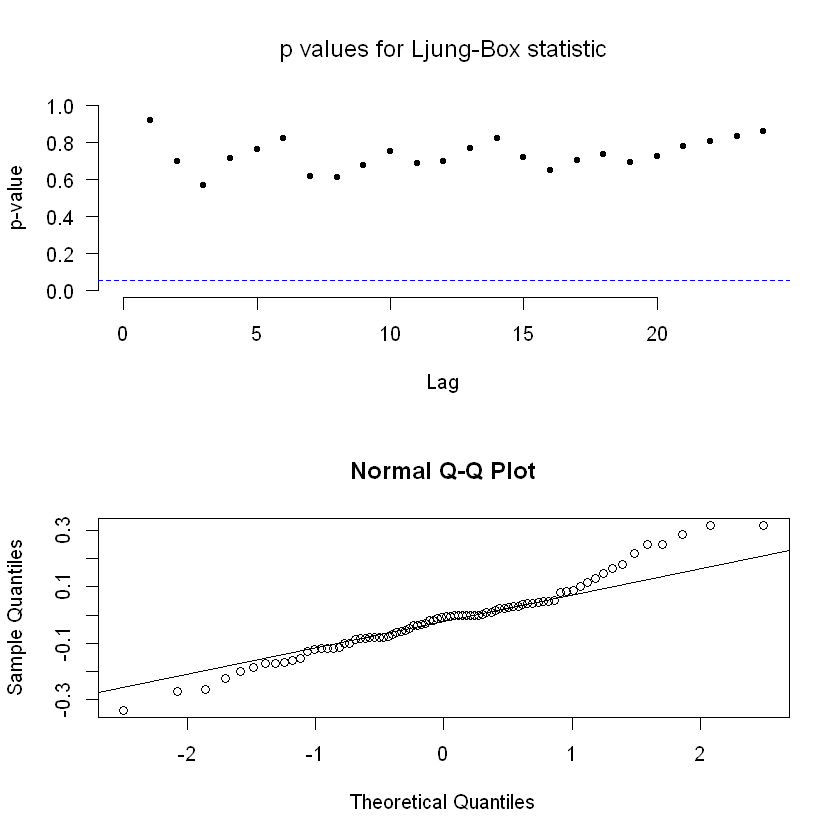

In [397]:
plot_diag(m7)

In [398]:
cor(fitted(m7),breaches)^2

[1] 0.9411026

## Total attendences



In [399]:
attends = ts(log(dtoc$total_atten_t1))

m8 = arima(breaches, order=c(0,1,1),
           seasonal = list(order =c(1,1,0), period = 12),
           xreg=data.frame(dtocs, admissions, attends), io=c(34));m8


Call:
arima(x = breaches, order = c(0, 1, 1), seasonal = list(order = c(1, 1, 0), 
    period = 12), xreg = data.frame(dtocs, admissions, attends), io = c(34))

Coefficients:
         ma1     sar1   dtocs  admissions  attends    IO.34
      -0.132  -0.6466  1.1489      1.6533   2.4039  -0.2917
s.e.   0.159   0.0956  0.5018      0.7744   0.6154   0.0852

sigma^2 estimated as 0.01773:  log likelihood = 36.76,  aic = -61.53

In [400]:
coeftest(m8)


z test of coefficients:

            Estimate Std. Error z value  Pr(>|z|)    
ma1        -0.132040   0.159046 -0.8302 0.4064231    
sar1       -0.646639   0.095639 -6.7613 1.368e-11 ***
dtocs       1.148927   0.501831  2.2895 0.0220521 *  
admissions  1.653285   0.774407  2.1349 0.0327690 *  
attends     2.403872   0.615381  3.9063 9.371e-05 ***
IO.34      -0.291725   0.085204 -3.4239 0.0006174 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


MA(1) no longer significant. drop from model

In [403]:
m8 = arima(breaches, order=c(0,1,0),
           seasonal = list(order =c(1,1,0), period = 12),
           xreg=data.frame(dtocs, admissions, attends), io=c(34));m8


Call:
arima(x = breaches, order = c(0, 1, 0), seasonal = list(order = c(1, 1, 0), 
    period = 12), xreg = data.frame(dtocs, admissions, attends), io = c(34))

Coefficients:
         sar1   dtocs  admissions  attends    IO.34
      -0.6448  1.0448      1.6587   2.3931  -0.2821
s.e.   0.0968  0.4807      0.7664   0.6116   0.0803

sigma^2 estimated as 0.01794:  log likelihood = 36.4,  aic = -62.79

In [405]:
coeftest(m8)


z test of coefficients:

            Estimate Std. Error z value  Pr(>|z|)    
sar1       -0.644811   0.096807 -6.6608 2.724e-11 ***
dtocs       1.044848   0.480684  2.1737 0.0297298 *  
admissions  1.658658   0.766438  2.1641 0.0304556 *  
attends     2.393081   0.611572  3.9130 9.116e-05 ***
IO.34      -0.282081   0.080299 -3.5129 0.0004433 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


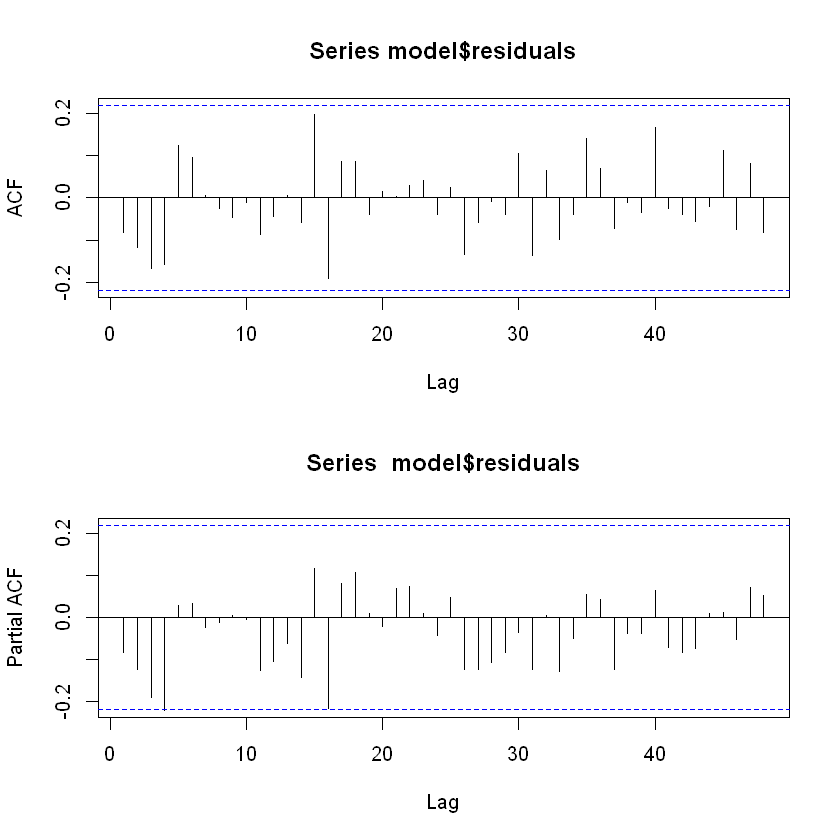

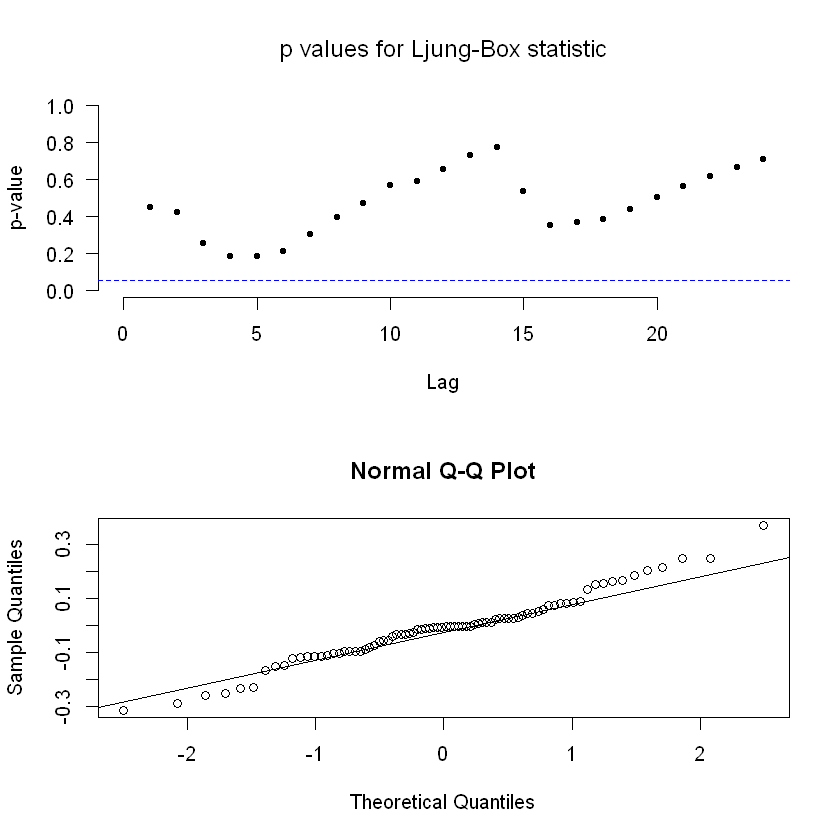

In [406]:
plot_diag(m8)

In [414]:
shapiro.test(m8$residuals)


	Shapiro-Wilk normality test

data:  m8$residuals
W = 0.97405, p-value = 0.103


CONCLUSIONS - diagnostics look okay.  No signs of autocorrelation and resids pass normality test.

### Final

In [407]:
cor(fitted(m8),breaches)^2

[1] 0.9443026

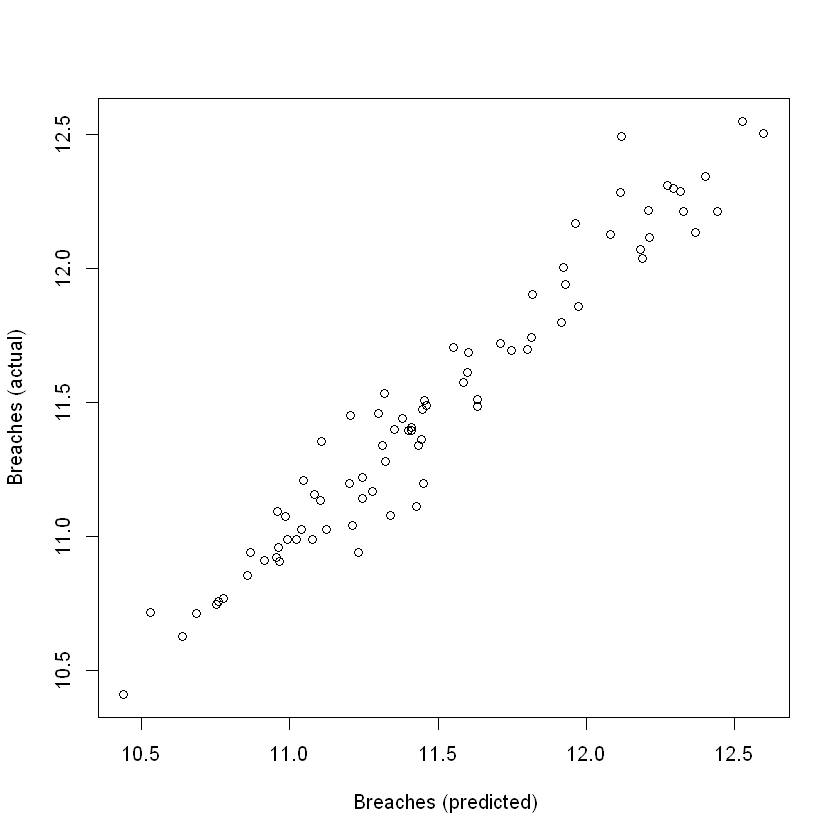

In [408]:
plot(as.vector(fitted(m8)), as.vector(breaches), ylab="Breaches (actual)", xlab=" Breaches (predicted)")

In [453]:
final_results <-function(m1, m2){
    cat('** unadjusted model **' )
    print(coeftest(m1))
    r1 <- cor(fitted(m1),breaches)^2
    
    cat("pseudo goodness of fit:", r1, "\n")
    
    cat("\n** adjusted model ** ")
    print(coeftest(m2))
    r2 <-cor(fitted(m2),breaches)^2
    cat("pseudo goodness of fit:", r2)
    
}

In [454]:
final_results(m6, m8)

** unadjusted model **
z test of coefficients:

       Estimate Std. Error  z value  Pr(>|z|)    
ar1    0.691464   0.106945   6.4656 1.009e-10 ***
ma1   -0.976969   0.056912 -17.1664 < 2.2e-16 ***
sar1  -0.695990   0.081265  -8.5645 < 2.2e-16 ***
dtocs  0.460597   0.362064   1.2721 0.2033219    
IO.34 -0.495316   0.148146  -3.3434 0.0008275 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

pseudo goodness of fit: 0.9388813 

** adjusted model ** 
z test of coefficients:

            Estimate Std. Error z value  Pr(>|z|)    
sar1       -0.644811   0.096807 -6.6608 2.724e-11 ***
dtocs       1.044848   0.480684  2.1737 0.0297298 *  
admissions  1.658658   0.766438  2.1641 0.0304556 *  
attends     2.393081   0.611572  3.9130 9.116e-05 ***
IO.34      -0.282081   0.080299 -3.5129 0.0004433 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

pseudo goodness of fit: 0.9443026

Interpretation of adjusted model.  (**remember these are national level data**)

1 percent increase in DToCs leads to a 1.04 percent increase in breaches.
1 percent increase in Admissions leads to a 1.65 percent increase in breaches
1 percent increase in attendences (type 1) leads to a 2.39% increase in breaches

**Notes: all data are logged.  Data are also difference - does that affect how I interpret?**